# Task Objective :

Given certain features about the applicant and the lending insitiute we are try to predict 

if the client / applicant who thought as undeserved client [with no or little  credit history] 

will repay the load or not [Defaulter or not] so it's a binary classification problem.


Non defaulter------------------->  0 class 

defaulter----------------------->  1  class

# Model Constraints:

1-Latency: 

this is not considerd as a real time application that needed to make inference in real time and the

latency would be considered as a big issue so this is an important point to consider while choosing

our model.[it's okay to take some time untill make inference.]
    
    
2-Interpretability :

this type of problems needs high degree of interpretability as we should choose track the test point of 

the applicant from entring the model to getting prediction and know how much features will contribute

in this prediction and output the prediction as a probability distribution.


3-Accuracy :

accuracy is a critical point in this task as in case of FP or FN we will have by rejecting 

good candidate or accepting a non deserving one so we must be careful while choosing our metric

of judgment

for the sake of our financial institute we must give more care for the Recall over the Precision as 

we are intersted for a model with low FN than FP 

# Imports

In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle 
import sklearn 
from pyspark.sql import SparkSession


# Read Data

In [2]:
Data_pandas=pd.read_csv("../Data/application_train.csv",index_col='SK_ID_CURR')

In [3]:
Data_pandas.shape

(307511, 121)

In [4]:
Data_pandas.head(3)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
100002          24700.5         351000.0  ...                0   
100003          35698.5        1129500.0  ...                0   
100004           6750.0         135000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   
100004                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  

[3 rows x 121 columns]

# Understanding data

In [5]:
EDA_Data=Data_pandas.copy()
EDA_Data.TARGET.replace({0:'Non_Defaulter',1:'Defaulter'},inplace=True)

# Check for nulls ratio

In [6]:
nulls_df=pd.DataFrame((EDA_Data.isna().sum()/EDA_Data.shape[0])*100,columns=['ratio of null']).sort_values(by='ratio of null',ascending=False)

In [7]:
nulls_df.head()

ratio of null
COMMONAREA_AVG                69.872297
COMMONAREA_MODE               69.872297
COMMONAREA_MEDI               69.872297
NONLIVINGAPARTMENTS_AVG       69.432963
NONLIVINGAPARTMENTS_MODE      69.432963

In [8]:
Features_to_drop=nulls_df[nulls_df['ratio of null']>30].index.tolist()

Theoretically features with more than 30% of missing values will be dropped and if 

less than this we will try to impute it with the best matching way. 

source: https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456

# Start Exploration

Data Explortation and Anlaysis can be done in several stages: 

1-look at satistical values like mean median mode skweness kurtosis scores

2-univariate Analysis : is to look at each feature distribution indiviually 

through Histogram or distplot or boxplot

3-Bivariate Anlaysis : to invistigate correlation and relationship between 

features throught scatter plot or heatmap


In [9]:
Categorical_features=[f for f in EDA_Data.columns  if EDA_Data[f].dtype=='O' and f!='TARGET']
Numerical_features=[f for f in EDA_Data.columns  if EDA_Data[f].dtype!='O']

1-Look At Stats

In [10]:
EDA_Data[Numerical_features].describe()

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  \
count  307511.000000      3.075110e+05  3.075110e+05  307499.000000   
mean        0.417052      1.687979e+05  5.990260e+05   27108.573909   
std         0.722121      2.371231e+05  4.024908e+05   14493.737315   
min         0.000000      2.565000e+04  4.500000e+04    1615.500000   
25%         0.000000      1.125000e+05  2.700000e+05   16524.000000   
50%         0.000000      1.471500e+05  5.135310e+05   24903.000000   
75%         1.000000      2.025000e+05  8.086500e+05   34596.000000   
max        19.000000      1.170000e+08  4.050000e+06  258025.500000   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  \
count     3.072330e+05               307511.000000  307511.000000   
mean      5.383962e+05                    0.020868  -16036.995067   
std       3.694465e+05                    0.013831    4363.988632   
min       4.050000e+04                    0.000290  -25229.000000   
25%       2.385000e+05                    0.010006  -19682.000000   
50%       4.500000e+05                    0.018850  -15750.000000   
75%       6.795000e+05                    0.028663  -12413.000000   
max       4.050000e+06                    0.072508   -7489.000000   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
count  307511.000000      307511.000000    307511.000000  ...   
mean    63815.045904       -4986.120328     -2994.202373  ...   
std    141275.766519        3522.886321      1509.450419  ...   
min    -17912.000000      -24672.000000     -7197.000000  ...   
25%     -2760.000000       -7479.500000     -4299.000000  ...   
50%     -1213.000000       -4504.000000     -3254.000000  ...   
75%      -289.000000       -2010.000000     -1720.000000  ...   
max    365243.000000           0.000000         0.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     

In [11]:
def Display_skew_kurt(df):
    skew= df.select_dtypes(np.number).skew()
    abs_skew = abs(skew)
    kurt = df.select_dtypes(np.number).kurt()
    skew_kurt_table = pd.concat([skew,abs_skew,kurt], axis = 1,
                                keys =['Skew','Absolute Skew','Kurtosis']).sort_values("Skew",ascending = False)
    skew_kurt_table['Skewed'] = skew_kurt_table['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
    return skew_kurt_table

In [12]:
Skew_df=Display_skew_kurt(EDA_Data)
Skew_df.groupby('Skewed').count()

Skew  Absolute Skew  Kurtosis
Skewed                               
False      7              7         7
True      97             97        97

We notice that Most of features are skeweed.

2-Univariate Analysis


-Categorical Features will be visualized as bar plot

-Numerical Features will be visualized by histogram or distplot 

-to display share of total use tree map

-to compare different cateogries use box plot



In [13]:
EDA_Data.TARGET.value_counts()

Non_Defaulter    282686
Defaulter         24825
Name: TARGET, dtype: int64

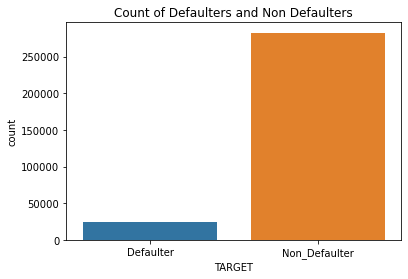

In [14]:
sns.countplot(data=EDA_Data,x='TARGET');
plt.title("Count of Defaulters and Non Defaulters");

As we thought there is a high class imbalance adressed in the data.

1-Categorical_Features

In [15]:
def Univariate_Analysis(df):
            for feature in Categorical_features:
                if feature !='ORGANIZATION_TYPE':
                    sns.countplot(data=df,x=feature,hue='TARGET')
                    plt.title('Comapre {} for the Target'.format(feature))
                    plt.xticks(rotation=45)
                    plt.show()

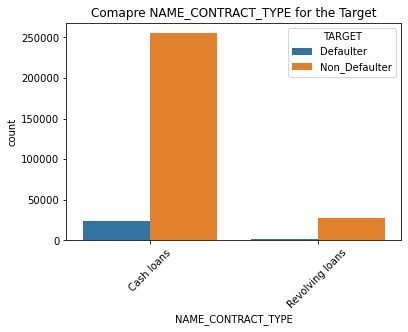

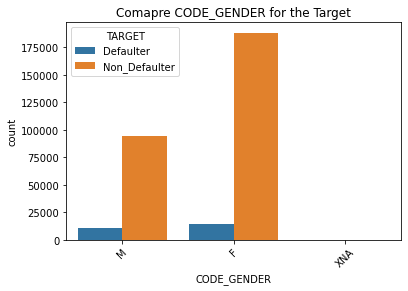

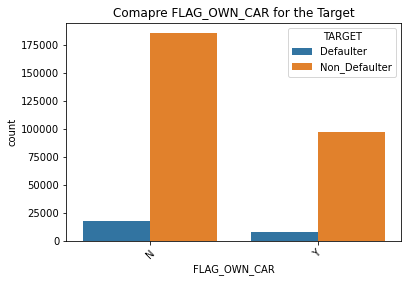

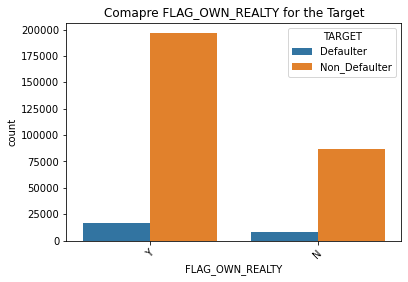

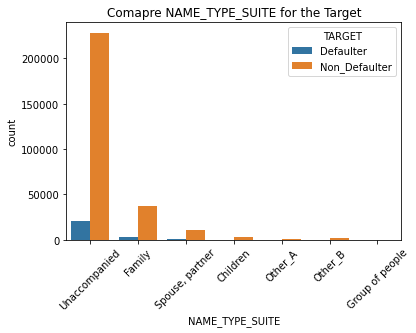

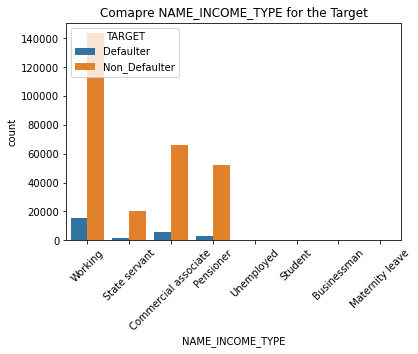

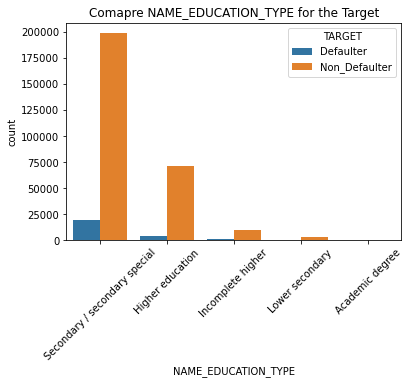

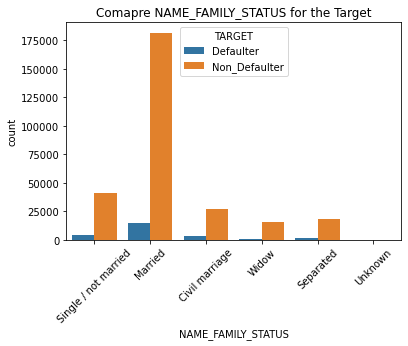

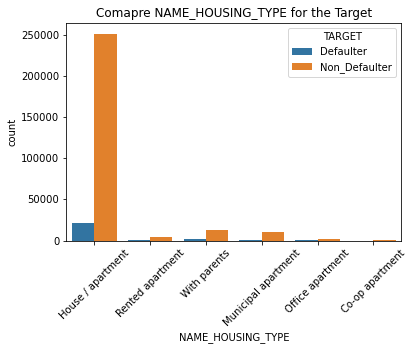

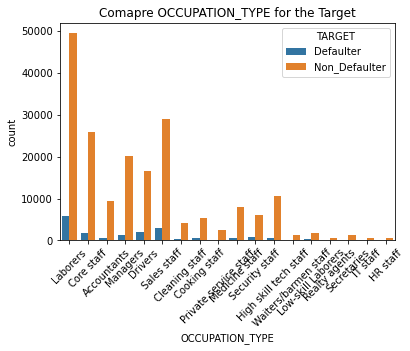

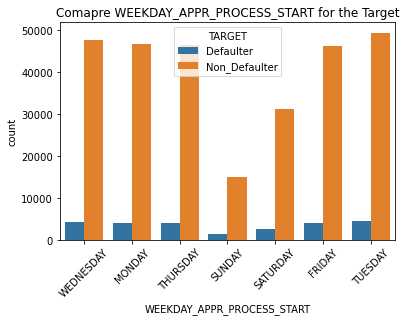

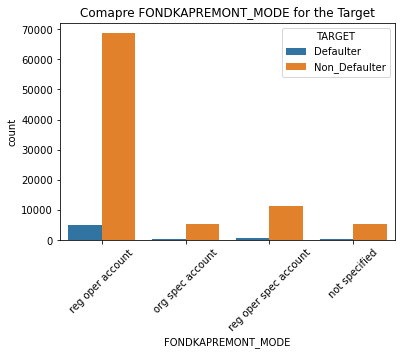

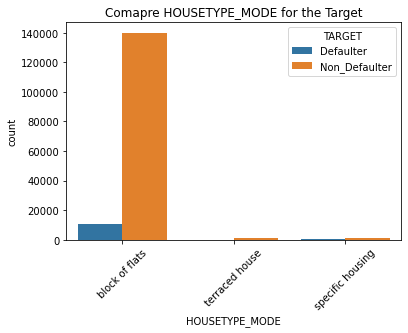

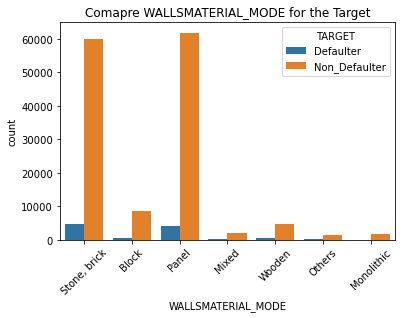

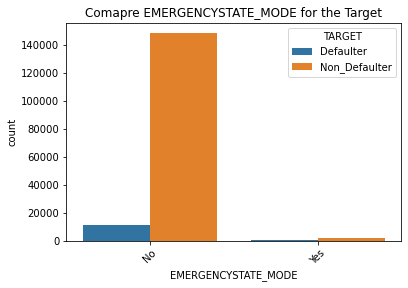

In [16]:
Univariate_Analysis(EDA_Data)

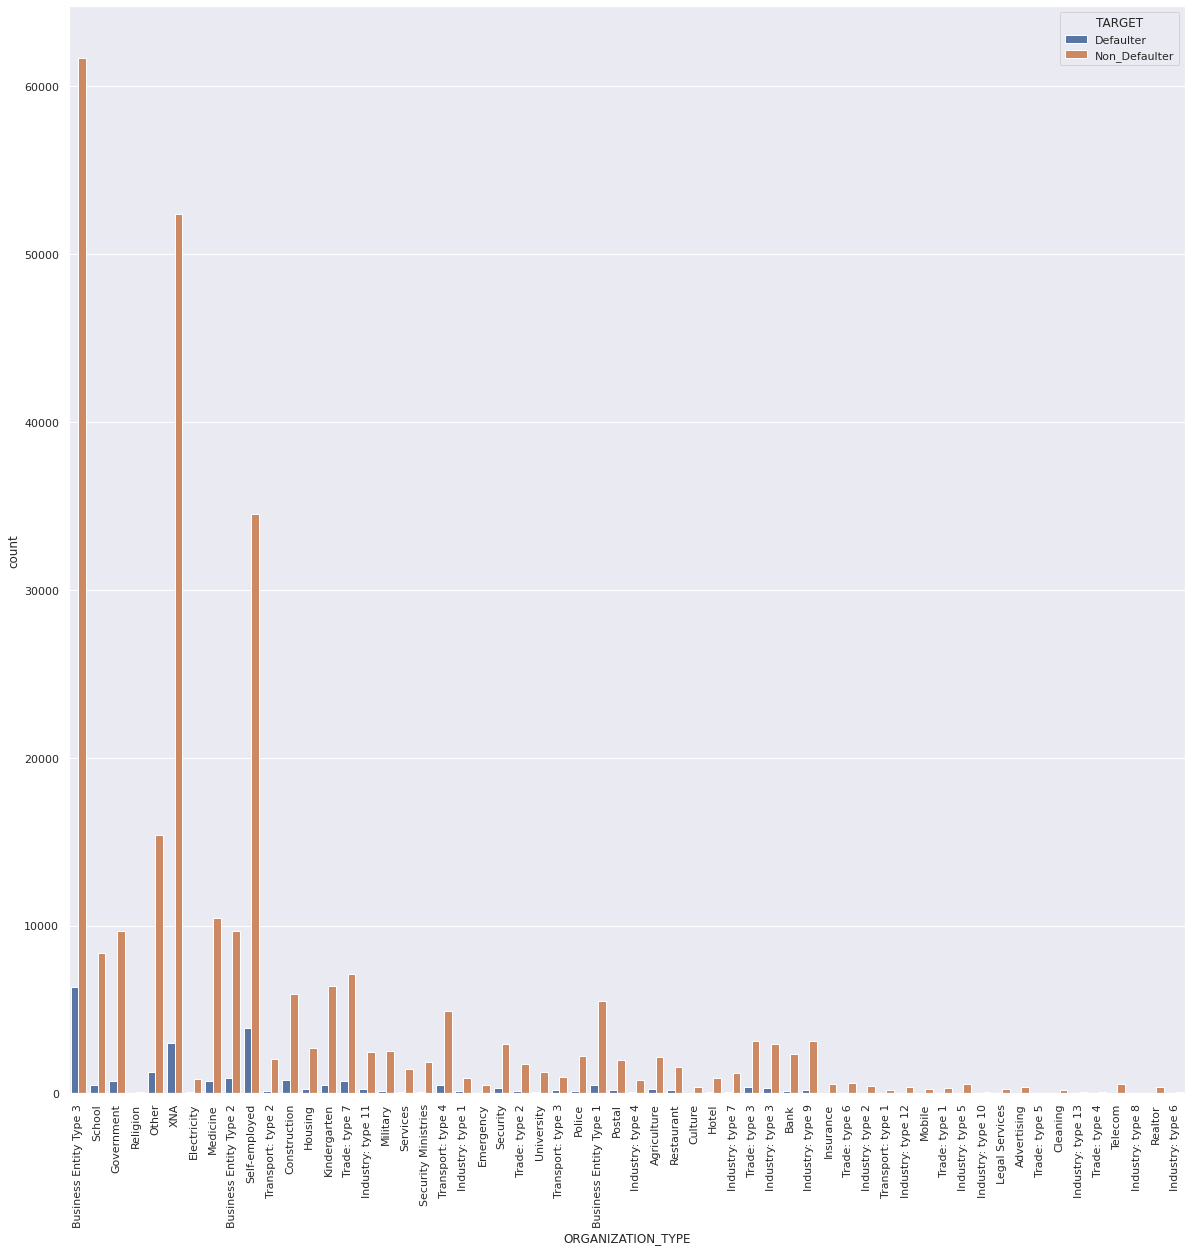

In [21]:
fig=sns.countplot(data=EDA_Data,x='ORGANIZATION_TYPE',hue='TARGET');
sns.set(rc={'figure.figsize':(20,20)})
plt.xticks(rotation=90)
plt.show()


Notes to include: 

1-Cash loans are more than revolving ones 

2-Females having loans more than Males

3-Most of loan applicants doesn't have cars but have realty 

4-Most of loan applicants are secondry special education 

5-Most of loan applicants are married

6-Most of loan applicants owning houses

7-Most of loan applicants are laborers

8-Monday , Wednesday and Tuesday are the most days the process start at

9-Most of loan applicants are not in emergency state 

10-Business entities and self employed orgs are most applying for loans.



=================================================================================

Organization types according to applying to loans

In [18]:
Data_org=EDA_Data.groupby(['ORGANIZATION_TYPE','TARGET']).NAME_CONTRACT_TYPE.agg('count').reset_index()

In [19]:
px.treemap(data_frame=Data_org,path=['ORGANIZATION_TYPE','TARGET'],values='NAME_CONTRACT_TYPE')

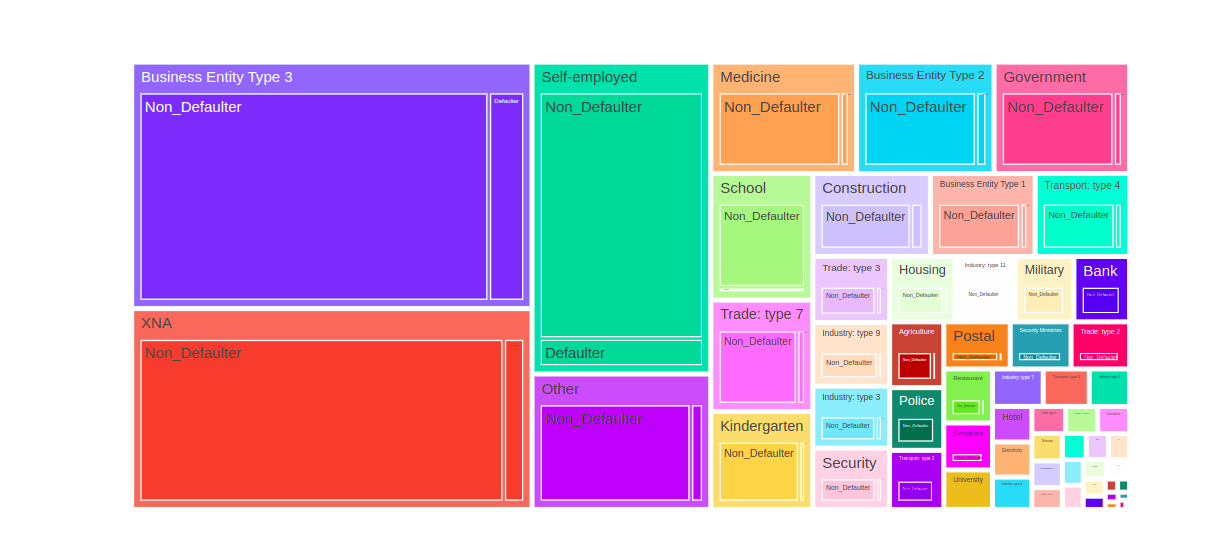

In [20]:
from IPython.display import Image
Image(filename='../Results/org_type.png') 

================================================================================

2-Numerical_features

Bucktizing number of childern to visualize it.

In [20]:
def NoChilds_group(x):
    x = int(x)
    x = abs(x)
    if( 0 < x < 2 ):
        return "0-1 childern"
    if( 2 < x < 4):
        return "2-3 childern"
    if( x>4):
        return "4 or more"

EDA_Data['childern_groups'] =EDA_Data['CNT_CHILDREN'].apply(NoChilds_group)


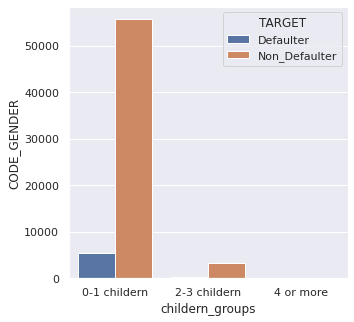

In [21]:
x=EDA_Data.groupby(['childern_groups','TARGET']).CODE_GENDER.agg('count').reset_index()
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=x,x='childern_groups',y='CODE_GENDER',hue='TARGET');

Most of loan applicants has 0-1 childern and most of them can repay the loan

======================================================================================

Now we want to look at total income for defaulter and non defaulter group

In [22]:
Income_defaulters=EDA_Data[EDA_Data['TARGET']=='Defaulter'].AMT_INCOME_TOTAL.values
Income_Nondefaulters=EDA_Data[EDA_Data['TARGET']=='Non_Defaulter'].AMT_INCOME_TOTAL.values

Text(0.5, 1.0, 'Income Comparison')

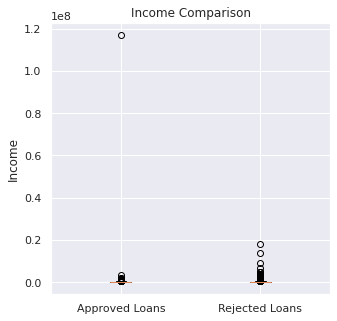

In [23]:
sns.set(rc={'figure.figsize':(5,5)})
plt.boxplot([Income_defaulters,Income_Nondefaulters])
plt.xticks([1,2],('Approved Loans','Rejected Loans'))
plt.ylabel('Income')
plt.title("Income Comparison")


Income data is massively right skewed and it appears that at some point clients with approved loans has higher 

incomes which makes sense.

==========================================================================================

Who takes more loans older people or youth and which are more defaulters?

In [25]:
AGE_defaulters=(EDA_Data[EDA_Data['TARGET']=='Defaulter'].DAYS_BIRTH.values*-1)/365
AGE_nondefaulters=(EDA_Data[EDA_Data['TARGET']=='Non_Defaulter'].DAYS_BIRTH.values*-1)/365

<AxesSubplot:title={'center':'Non Defaulters Age Distribution'}, xlabel='Age', ylabel='Count'>

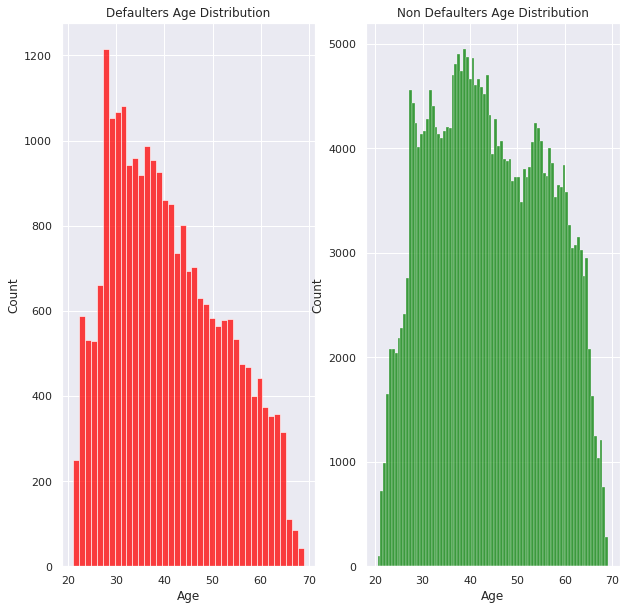

In [27]:
f, ax = plt.subplots(1, 2)
sns.set(rc={'figure.figsize':(10,10)})
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Age")
ax[1].set_xlabel("Age")
ax[0].title.set_text("Defaulters Age Distribution")
ax[1].title.set_text("Non Defaulters Age Distribution")
sns.histplot(AGE_defaulters,color='red',ax=ax[0])
sns.histplot(AGE_nondefaulters,color='green',ax=ax[1])


-distribution of non defaultors is multimodal normal distribution.

-It seems that the peak number of defaulters are in the age ~ 28 and start to decreases as the age increases.

=======================================================================================

External_source feature

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



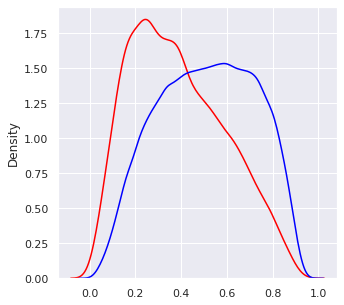

In [30]:
defaulter_extsrc1=EDA_Data[EDA_Data['TARGET']=='Defaulter']['EXT_SOURCE_1'].values
nondefaulter_extsrc1= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['EXT_SOURCE_1'].values
sns.distplot(defaulter_extsrc1,color='red',hist=False)
sns.distplot(nondefaulter_extsrc1,color='blue',hist=False)
sns.set(rc={'figure.figsize':(5,5)})

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



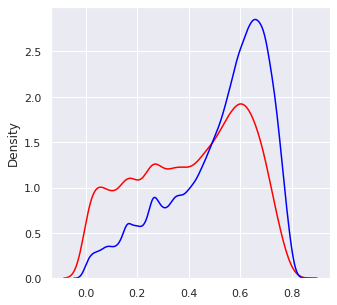

In [31]:
defaulter_extsrc2=EDA_Data[EDA_Data['TARGET']=='Defaulter']['EXT_SOURCE_2'].values
nondefaulter_extsrc2= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['EXT_SOURCE_2'].values
sns.distplot(defaulter_extsrc2,color='red',hist=False)
sns.distplot(nondefaulter_extsrc2,color='blue',hist=False)
sns.set(rc={'figure.figsize':(5,5)})

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



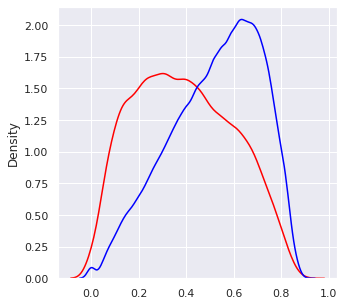

In [32]:
defaulter_extsrc3=EDA_Data[EDA_Data['TARGET']=='Defaulter']['EXT_SOURCE_3'].values
nondefaulter_extsrc3= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['EXT_SOURCE_3'].values
sns.distplot(defaulter_extsrc3,color='red',hist=False)
sns.distplot(nondefaulter_extsrc3,color='blue',hist=False)
sns.set(rc={'figure.figsize':(5,5)})

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



<AxesSubplot:ylabel='Density'>

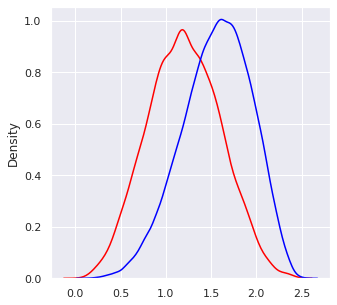

In [33]:
ext_src_d=defaulter_extsrc1+defaulter_extsrc2+defaulter_extsrc3
ext_src_n=nondefaulter_extsrc1+nondefaulter_extsrc2+nondefaulter_extsrc3
sns.distplot(ext_src_d,color='red',hist=False)
sns.distplot(ext_src_n,color='blue',hist=False)

it seems that each feature of ext src has distingushing info between our classes and

adding them all can generate new feature seems important for us.

=============================================================

Days_Last_phone_Change

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

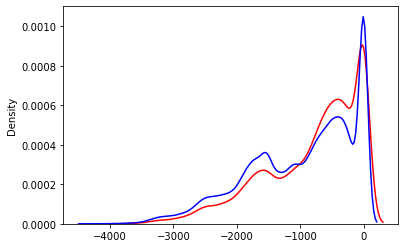

In [17]:
defaulter_phonechg=EDA_Data[EDA_Data['TARGET']=='Defaulter']['DAYS_LAST_PHONE_CHANGE'].values
nondefaulter_phonechg= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['DAYS_LAST_PHONE_CHANGE'].values
sns.distplot(defaulter_phonechg,color='red',hist=False)
sns.distplot(nondefaulter_phonechg,color='blue',hist=False)

==================================================================

Now i will try to build a naive assumption that changing phone has relation of being employed

and taking a load

/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

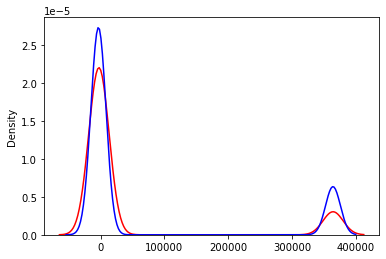

In [21]:
defaulter_phonechg=EDA_Data[EDA_Data['TARGET']=='Defaulter']['DAYS_LAST_PHONE_CHANGE'].values
nondefaulter_phonechg= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['DAYS_LAST_PHONE_CHANGE'].values
#########################################################################
defaulter_emp=EDA_Data[EDA_Data['TARGET']=='Defaulter']['DAYS_EMPLOYED'].values
nondefaulter_emp= EDA_Data[EDA_Data['TARGET']=='Non_Defaulter']['DAYS_EMPLOYED'].values
sns.distplot(defaulter_phonechg+defaulter_emp,color='red',hist=False)
sns.distplot(nondefaulter_phonechg+nondefaulter_emp,color='blue',hist=False)

# BiVariate Relations 

Which occupation has higher income and does they repay thier loan?? let's see

In [32]:
occupation_income_df=EDA_Data.groupby(['OCCUPATION_TYPE', 'TARGET'])['AMT_INCOME_TOTAL'].mean().unstack()

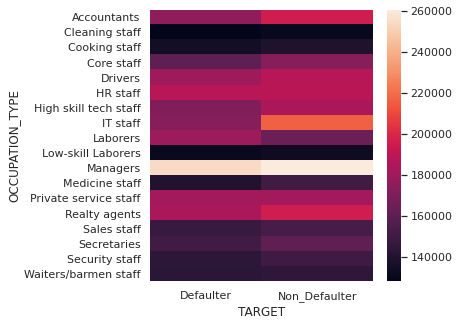

In [39]:
sns.heatmap(occupation_income_df);
sns.set(rc={'figure.figsize':(3,3)})

-hmmm interesting....Managers are the highest total incomes while cleaning and cooking staff  are the least.

-most of the defaulters has lower income than the non defaultors in most of the occupations except for

the laborers which is surprising...remember that laborers were the most occupation having loans.



========================================================================

Let's make it again but now with organizations

In [34]:
organiztion_income_df=EDA_Data.groupby(['ORGANIZATION_TYPE', 'TARGET'])['AMT_INCOME_TOTAL'].mean().unstack()

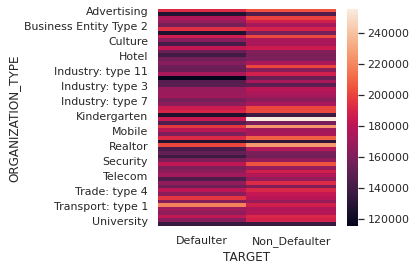

In [41]:
sns.heatmap(organiztion_income_df);
sns.set(rc={'figure.figsize':(4,4)})

-there is a gap between the total income for those who are defaulter and non defaulter for same organization

-some organization's defaulters have higher income like trade type 7 and transporter .

==========================================================================

Is there a correlation between income and credit?

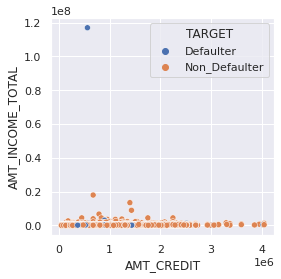

In [42]:
sns.scatterplot(data=EDA_Data,x='AMT_CREDIT',y='AMT_INCOME_TOTAL',hue='TARGET');
sns.set(rc={'figure.figsize':(5,5)})

NO relation can be observed.....what about annuity with credit....we expect to see relation there

as the higher yearly income the higher credit in the bank

======================================================================

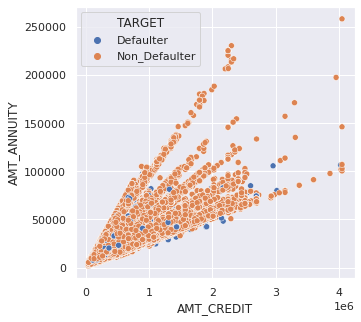

In [43]:
sns.scatterplot(data=EDA_Data,x='AMT_CREDIT',y='AMT_ANNUITY',hue='TARGET');
sns.set(rc={'figure.figsize':(5,5)})

====================================================================

Does non defaulters sell goods with higher price help them to repay their loan?

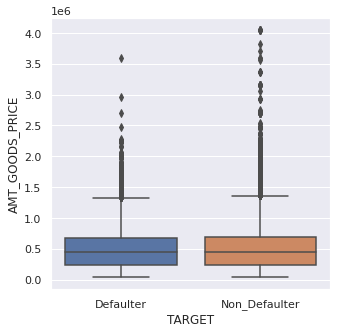

In [44]:
sns.boxplot(data=EDA_Data,x='TARGET',y='AMT_GOODS_PRICE')
sns.set(rc={'figure.figsize':(5,5)})

they almost have same median and iqr except for some higher oultiers for non defaulters.

I wish i could have more time to invistigate the rest of features and csv files but let's move to feature 

generation and prepartion

============================================================================

Flag document: document that should be signed according to taking the loan.

In [45]:
Flag_Doc_df=EDA_Data.loc[:, EDA_Data.columns.str.match('FLAG_DOCUMENT_*')]
Flag_Doc_df['TARGET']=EDA_Data.TARGET

/tmp/ipykernel_5868/2602633161.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
for col in Flag_Doc_df.columns:
    if col != 'TARGET':
        print(Flag_Doc_df.groupby(col)['TARGET'].agg('count'))
        print("===========================================================")
        

FLAG_DOCUMENT_2
0    307498
1        13
Name: TARGET, dtype: int64
FLAG_DOCUMENT_3
0     89171
1    218340
Name: TARGET, dtype: int64
FLAG_DOCUMENT_4
0    307486
1        25
Name: TARGET, dtype: int64
FLAG_DOCUMENT_5
0    302863
1      4648
Name: TARGET, dtype: int64
FLAG_DOCUMENT_6
0    280433
1     27078
Name: TARGET, dtype: int64
FLAG_DOCUMENT_7
0    307452
1        59
Name: TARGET, dtype: int64
FLAG_DOCUMENT_8
0    282487
1     25024
Name: TARGET, dtype: int64
FLAG_DOCUMENT_9
0    306313
1      1198
Name: TARGET, dtype: int64
FLAG_DOCUMENT_10
0    307504
1         7
Name: TARGET, dtype: int64
FLAG_DOCUMENT_11
0    306308
1      1203
Name: TARGET, dtype: int64
FLAG_DOCUMENT_12
0    307509
1         2
Name: TARGET, dtype: int64
FLAG_DOCUMENT_13
0    306427
1      1084
Name: TARGET, dtype: int64
FLAG_DOCUMENT_14
0    306608
1       903
Name: TARGET, dtype: int64
FLAG_DOCUMENT_15
0    307139
1       372
Name: TARGET, dtype: int64
FLAG_DOCUMENT_16
0    304458
1      3053
Name: TARGET, d

As expected small no of applicant who are defaultors sign these documents due to class imbalance in data.